In [1]:
# Running All Imports
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline
import sys
print(sys.version)


from qiskit import pulse, QuantumCircuit, ClassicalRegister#, IBMQ

from qiskit_ibm_runtime import QiskitRuntimeService

#from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional


# IBMQ.save_account("TOKEN", overwrite=True)
# Run previous line with the appropriate token
# service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/b500a23b61df4c36a9f1eef14a04227d:a6e2883a-5882-4f71-9942-1e480bb96768::")
service = QiskitRuntimeService()
print(service)

3.9.11 (v3.9.11:2de452f8bf, Mar 16 2022, 10:34:36) 
[Clang 6.0 (clang-600.0.57)]
<QiskitRuntimeService>


In [2]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider.backends()
### SHERBROOKE DETAILS ###
backend = service.backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 0
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [3]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7f813a053fd0>
backend_name
ibm_sherbrooke
backend_version
1.5.4
n_qubits
127
basis_gates
['ecr', 'id', 'rz', 'sx', 'x']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], 

## Running 2-Step Reset Sweep
1. Effectively do Kappa Experiment but with varying duration reset tone, play measurement after reset tone and see how long it takes to reach photon population minima
2. Decide on ideal photon population for second kickback tone and play kickback tone


## Experiments running in this notebook
1. Re-run Measurement Photon Meas and Kappa Meas with smaller windows
2. Run First Reset Tone calibration with calibrated tau-1 ring-up and evaluate performance

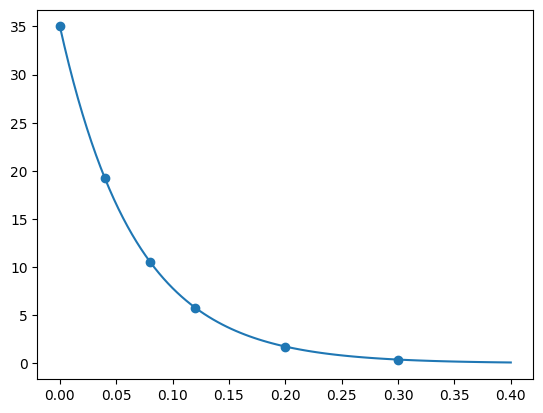

In [4]:
approx_kappa = 15.0
approx_init_photon_pop = 35.0

kappa_times_us = np.array([0., 40., 80., 120., 200., 300.]) * ns
plot_linspace = np.linspace(0., 0.4, 101)

plt.scatter(kappa_times_us/us, approx_init_photon_pop * np.exp(-approx_kappa * kappa_times_us / us))
plt.plot(plot_linspace, approx_init_photon_pop * np.exp(-approx_kappa * plot_linspace))
plt.show()

In [5]:
from utils import convert_arr_to_dt, get_dt_from

kappa_delays = kappa_times_us
kappa_delays_us = convert_arr_to_dt(kappa_delays)

kappa_freq_span = 20. * MHz
kappa_center = -2.5 * MHz
num_kappa_exps = 98
kappa_freq_linspace = np.linspace(-0.5 * kappa_freq_span, 0.5 * kappa_freq_span, num_kappa_exps) + kappa_center

print(f"Freq Precision: {(kappa_freq_linspace[1] - kappa_freq_linspace[0]) / MHz}MHz")

print(kappa_delays_us / ns)

Freq Precision: 0.20618556701030955MHz
[  0.          39.11111111  78.22222222 120.88888889 199.11111111
 298.66666667]


588


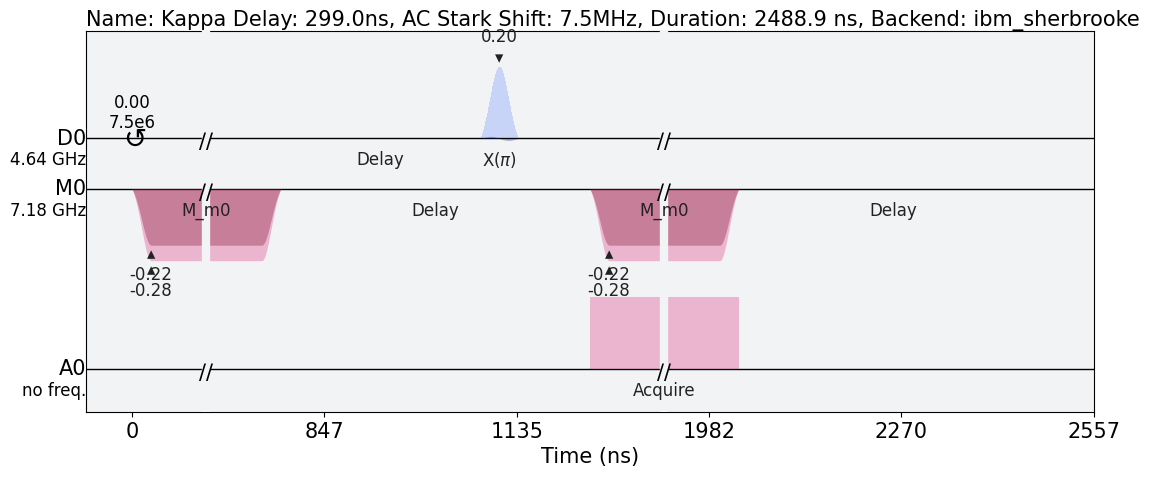

In [6]:
kappa_exps = []

for kappa_delay_sec in kappa_delays_us:
    kappa_delay_dt = get_dt_from(kappa_delay_sec)    

    for kappa_stark_shift_freq in kappa_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Kappa Delay: {np.round(kappa_delay_dt*dt/ns)}ns, AC Stark Shift: {np.round(kappa_stark_shift_freq/MHz, 3)}MHz'
        ) as kappa_ac_stark_shift:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(kappa_stark_shift_freq, qubit_chan) # Shift Qubit Chan Frequency
            pulse.play(measure_pulse, meas_chan) # Play Measure Pulse
            with pulse.align_left():
                if kappa_delay_sec != 0.:
                    pulse.delay(kappa_delay_dt, qubit_chan)
                pulse.play(x_pulse, qubit_chan) # Play Sharp Qubit Tone (X-Pulse)
                pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        kappa_exps.append(kappa_ac_stark_shift)

print(len(kappa_exps))

kappa_exps[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

[ 4.89940993  2.42182637  0.99019346  0.49636096  3.69145853 24.36994786]


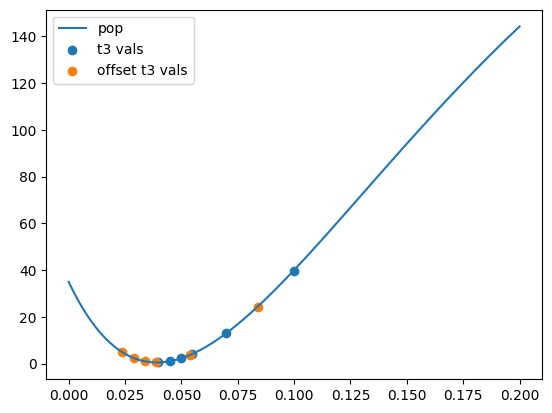

In [7]:
cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns

kappa = 15.08 # From AC Stark-Shift based Photon Measurement
chi = 0.335 * 2 * np.pi
N0 = 35.0
mu = 1/measure_pulse.amp
rough_tau_3_us = 2 / kappa * np.log((mu + 1) / (mu))

tau_3_vals = np.array([
    rough_tau_3_us,
    rough_tau_3_us + 0.005,
    rough_tau_3_us + 0.010,
    rough_tau_3_us + 0.015,
    rough_tau_3_us + 0.030,
    rough_tau_3_us + 0.060,
]) * us
plot_t123_linspace = np.linspace(0., 0.2, 101)

def realistic_photon_pop(t, N0, k, c, u):
    return N0 * (u**2 + (u+1)**2 * np.exp(-k * t) - 2. * u * (u + 1) * np.exp(-0.5 * k * t) * np.cos(0.5 * c * t))

plt.plot(plot_t123_linspace, realistic_photon_pop(plot_t123_linspace, N0, kappa, chi, mu), label='pop')
plt.scatter(tau_3_vals/us, realistic_photon_pop(tau_3_vals/us, N0, kappa, chi, mu), label='t3 vals')
plt.scatter(tau_3_vals/us - 0.016, realistic_photon_pop(tau_3_vals/us - 0.016, N0, kappa, chi, mu), label='offset t3 vals')
print(realistic_photon_pop(tau_3_vals/us - 0.016, N0, kappa, chi, mu))
plt.legend()
plt.show()

Extra Delay: 14.222222222222221


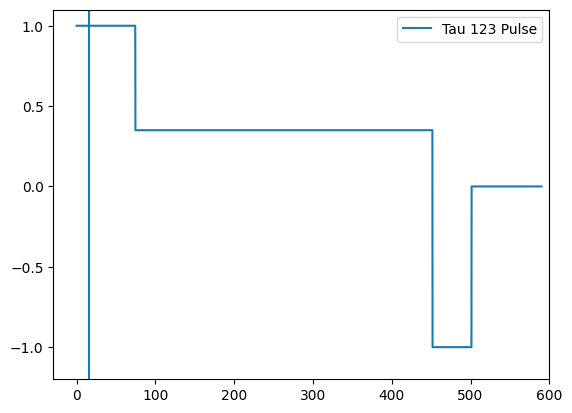

In [8]:
cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns

meas_pulse_dur_dt = get_dt_from(cal_tau_2 + tau_3_vals[-1] + 40. * ns)
extra_delay_dt = get_dt_from(15. * ns)
print(f"Extra Delay: {extra_delay_dt * dt / ns}")

def get_tau_123_waveform(tau_1_dur_dt, tau_2_dur_dt, tau_3_dur_dt, total_dur_dt):
    t123_times = np.arange(total_dur_dt) * dt
    tau_123_pulse = measure_pulse.amp * np.heaviside(t123_times - tau_1_dur_dt * dt, 1.) * np.heaviside(tau_2_dur_dt * dt - t123_times, 1.)
    tau_123_pulse += np.heaviside(tau_1_dur_dt * dt - t123_times, 0.) # add tau 1 ring-up
    tau_123_pulse -= np.heaviside((tau_2_dur_dt + tau_3_dur_dt) * dt - t123_times, 0.) * np.heaviside(t123_times - (tau_2_dur_dt) * dt, 0.)
    return tau_123_pulse

example_tau_3 = tau_3_vals[2]

tau_123_pulse = get_tau_123_waveform(
    get_dt_from(cal_tau_1, dt), 
    get_dt_from(cal_tau_2, dt),
    get_dt_from(example_tau_3, dt),
    meas_pulse_dur_dt
)

t_plot = np.arange(len(tau_123_pulse)) * dt / ns
plt.plot(t_plot, tau_123_pulse, label='Tau 123 Pulse')
plt.axvline(x=16)
plt.ylim(bottom=-1.2)
plt.xlim(right=600)
plt.legend()
plt.show()

588


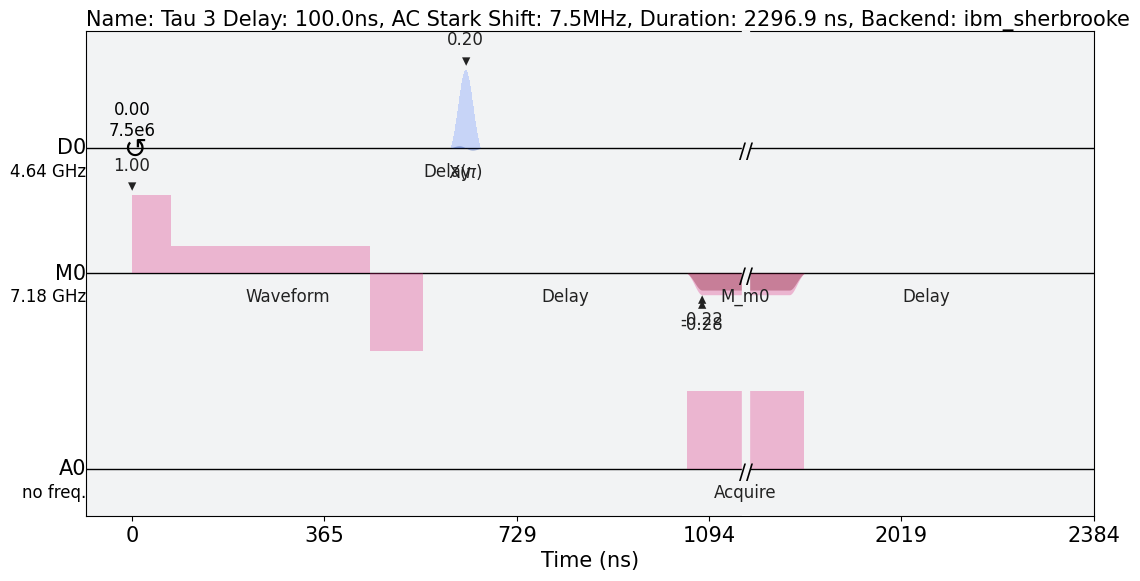

In [9]:
tau_3_exps = []

for tau_3_sec in tau_3_vals:
    tau_3_dt = get_dt_from(tau_3_sec)
    tau_3_pulse = tau_123_pulse = get_tau_123_waveform(
        get_dt_from(cal_tau_1, dt), 
        get_dt_from(cal_tau_2, dt),
        tau_3_dt,
        meas_pulse_dur_dt
    )

    for tau_3_stark_shift_freq in kappa_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Tau 3 Delay: {np.round(tau_3_dt*dt/ns)}ns, AC Stark Shift: {np.round(tau_3_stark_shift_freq/MHz, 3)}MHz'
        ) as tau_3_ac_stark_shift:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(tau_3_stark_shift_freq, qubit_chan) # Shift Qubit Chan Frequency
            pulse.play(tau_3_pulse, meas_chan) # Play Measure Pulse
            with pulse.align_left():
                pulse.delay(extra_delay_dt, qubit_chan)
                pulse.play(x_pulse, qubit_chan) # Play Sharp Qubit Tone (X-Pulse)
                pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_3_exps.append(tau_3_ac_stark_shift)

print(len(tau_3_exps))

tau_3_exps[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

294
294
294
294


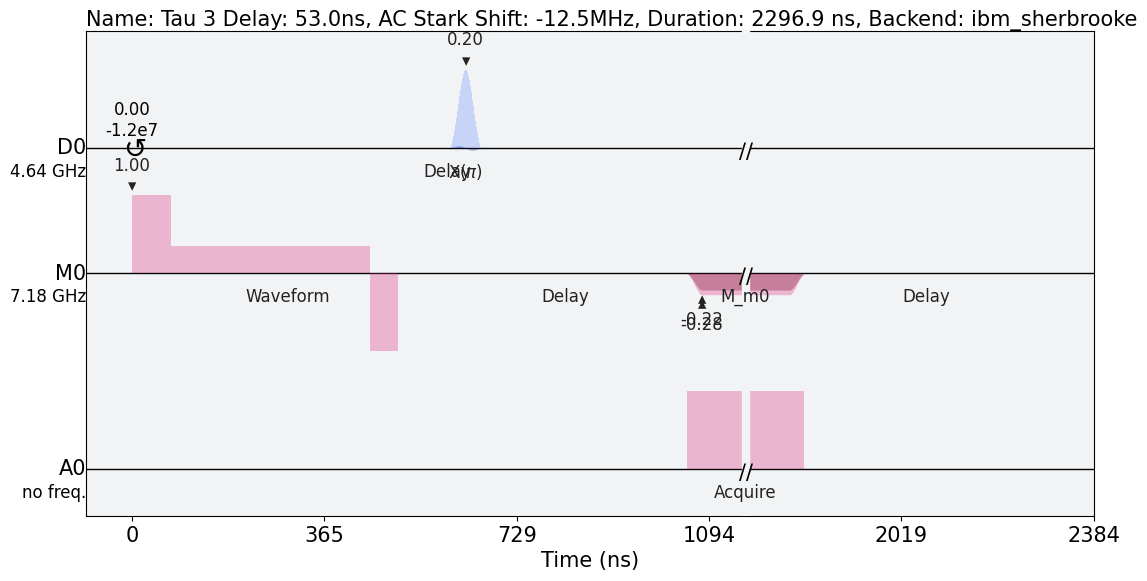

In [10]:
from utils import acquisition_checker

big_exps = kappa_exps + tau_3_exps

acquisition_checker(big_exps, backend)

big_exps_arr = np.array(big_exps).reshape(4, -1)
big_exp_1, big_exp_2, big_exp_3, big_exp_4 = big_exps_arr.tolist()

print(len(big_exp_1))
print(len(big_exp_2))
print(len(big_exp_3))
print(len(big_exp_4))

num_shots = 4096
rep_delay = 2. * us

big_exp_4[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_1, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_3, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

In [14]:
# Analysing Results

import json

with open('july_results/cqjmf9l2h48lmf6n4npg-result.json') as f:
    kappa_jobs_1 = json.load(f)
# print(kappa_jobs_1)

with open('july_results/cqjmfdlf3b4ctiaebgpg-result.json') as f:
    kappa_jobs_2 = json.load(f)
# print(kappa_jobs_2)

with open('july_results/cqjmfgps5e15grc5tsk0-result.json') as f:
    tau_jobs_1 = json.load(f)
# print(tau_jobs_1)

with open('july_results/cqjmfj3q5itdpae1o8d0-result.json') as f:
    tau_jobs_2 = json.load(f)
# print(tau_jobs_2)

In [15]:
kappa_results_1 = kappa_jobs_1["results"]
kappa_results_2 = kappa_jobs_2["results"]
tau_results_1 = tau_jobs_1["results"]
tau_results_2 = tau_jobs_2["results"]
print(len(kappa_results_1))
print(len(kappa_results_2))
print(len(tau_results_1))
print(len(tau_results_2))

294
294
294
294


In [16]:
big_list_kappa_1 = []

for res_obj in kappa_results_1:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_kappa_1.append(temp)

big_array_kappa_1 = np.array(big_list_kappa_1)

big_list_kappa_2 = []

for res_obj in kappa_results_2:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_kappa_2.append(temp)

big_array_kappa_2 = np.array(big_list_kappa_2)

big_list_tau_1 = []

for res_obj in tau_results_1:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_tau_1.append(temp)

big_array_tau_1 = np.array(big_list_tau_1)

big_list_tau_2 = []

for res_obj in tau_results_2:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_tau_2.append(temp)

big_array_tau_2 = np.array(big_list_tau_2)

print(big_array_kappa_1.shape)
print(big_array_tau_1.shape)

(294, 4096, 2)
(294, 4096, 2)


In [17]:
# Analysing Kappa Experiments
big_array_kappa_1_complex = big_array_kappa_1[:,:,0] + 1.0j * big_array_kappa_1[:,:,1]
big_array_kappa_2_complex = big_array_kappa_2[:,:,0] + 1.0j * big_array_kappa_2[:,:,1]
big_array_tau_1_complex = big_array_tau_1[:,:,0] + 1.0j * big_array_tau_1[:,:,1]
big_array_tau_2_complex = big_array_tau_2[:,:,0] + 1.0j * big_array_tau_2[:,:,1]

mean_kappa_1 = np.mean(big_array_kappa_1_complex, axis=-1)
mean_kappa_2 = np.mean(big_array_kappa_2_complex, axis=-1)
mean_tau_1 = np.mean(big_array_tau_1_complex, axis=-1)
mean_tau_2 = np.mean(big_array_tau_2_complex, axis=-1)
mean_kappa = np.concatenate((mean_kappa_1, mean_kappa_2))
mean_tau = np.concatenate((mean_tau_1, mean_tau_2))
angle_kappa = np.angle(mean_kappa)
angle_tau = np.angle(mean_tau)
angle_kappa_reshaped = angle_kappa.reshape(6, -1)
angle_tau_reshaped = angle_tau.reshape(6, -1)

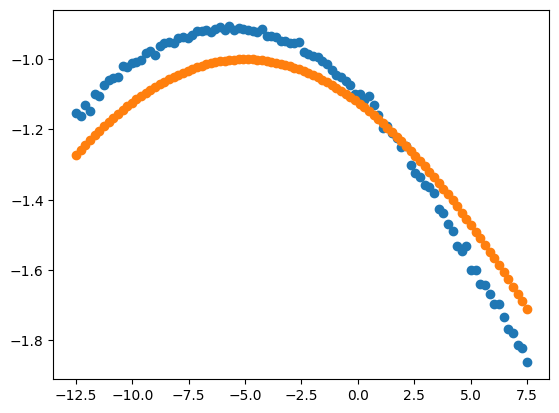

In [31]:
guess_params = [4., 20., -5., -5.]

plt.scatter(kappa_linspace_MHz, angle_kappa_reshaped[0])
plt.scatter(kappa_linspace_MHz, gaussian_func(kappa_linspace_MHz, *guess_params))
plt.show()

In [34]:
# Analysing Steady State Data

def gaussian_func(x, a, c, b, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d
init_params = [4., 20., -5., -5.]

# Analysing Kappa Results
kappa_linspace_MHz = kappa_freq_linspace / MHz
kappa_fit_params = []
kappa_fit_freqs = np.zeros(len(kappa_delays))

for i, kappa_exp_angles in enumerate(angle_kappa_reshaped):
    k_params, k_cov = curve_fit(
        gaussian_func, 
        kappa_linspace_MHz, 
        kappa_exp_angles, 
        init_params,
        maxfev=5000
    )
    k_freq = k_params[2]
    kappa_fit_freqs[i] = np.round(k_freq, 3)
    kappa_fit_params.append(k_params)

# Analysing Tau Results
tau_linspace_MHz = kappa_freq_linspace / MHz
tau_fit_params = []
tau_fit_freqs = np.zeros(len(tau_3_vals))

for i, tau_exp_angles in enumerate(angle_tau_reshaped):
    t_params, t_cov = curve_fit(
        gaussian_func, 
        tau_linspace_MHz, 
        tau_exp_angles, 
        init_params,
        maxfev=5000
    )
    t_freq = t_params[2]
    tau_fit_freqs[i] = np.round(t_freq, 3)
    tau_fit_params.append(t_params)

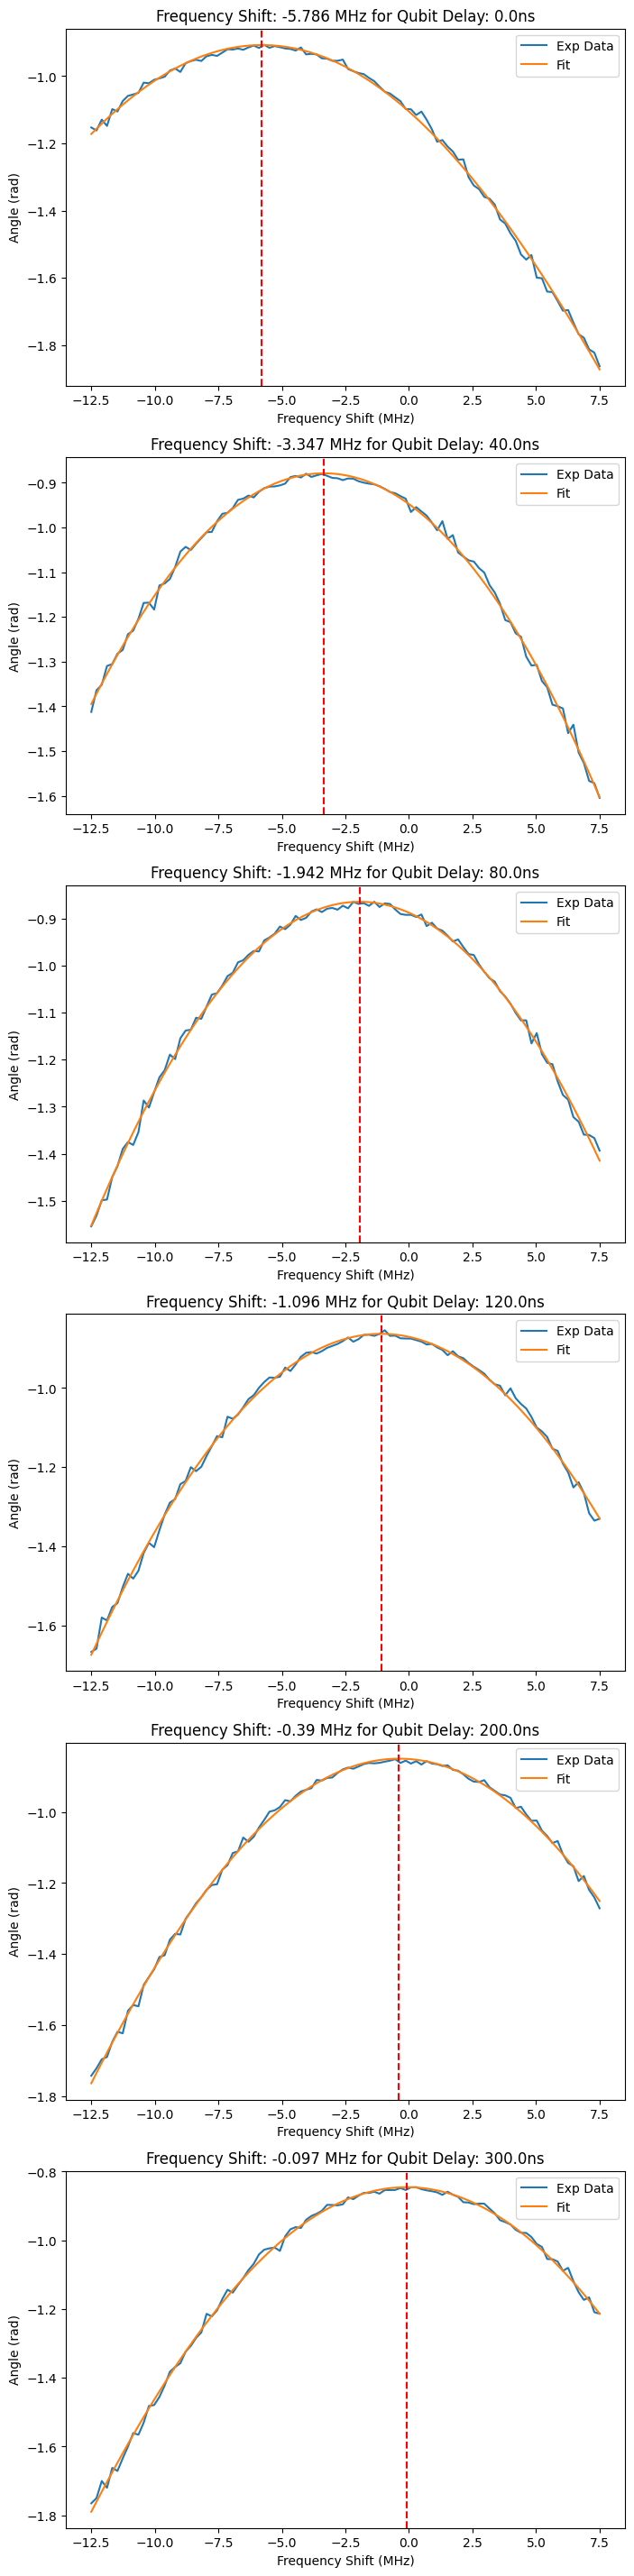

In [35]:
# Plotting Results

fig, ax = plt.subplots(len(kappa_delays), figsize=(8.0, 6.0 * len(kappa_delays)))

kappa_q_delays_ns = np.round(kappa_delays/ns, 2)

for i, (k_freq, k_params, k_exp_res) in enumerate(zip(kappa_fit_freqs, kappa_fit_params, angle_kappa_reshaped)):
    ax[i].plot(kappa_linspace_MHz, k_exp_res, label='Exp Data')
    ax[i].plot(kappa_linspace_MHz, gaussian_func(kappa_linspace_MHz, *k_params), label='Fit')
    ax[i].axvline(x=k_freq, linestyle='dashed', color='red')
    ax[i].set_xlabel('Frequency Shift (MHz)')
    ax[i].set_ylabel('Angle (rad)')
    ax[i].set_title(f'Frequency Shift: {k_freq} MHz for Qubit Delay: {kappa_q_delays_ns[i]}ns')
    ax[i].legend()

plt.show()

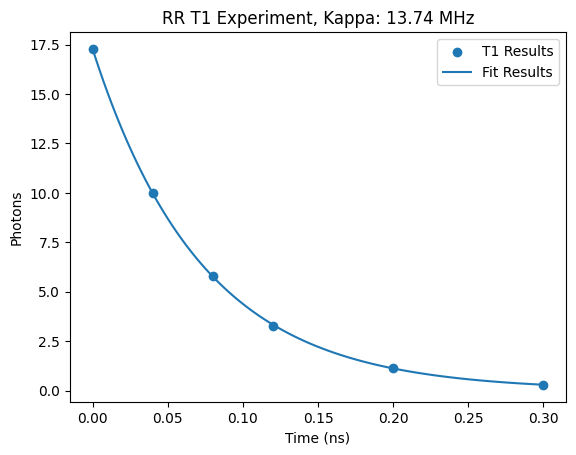

In [36]:
sherbrooke_chi_MHz = 0.335
kappa_fit_photons = -kappa_fit_freqs / sherbrooke_chi_MHz

def exp_decay_func(t, amp, kappa, offset):
    return amp * np.exp(-kappa * t) + offset

init_photon_params = [50., 20., 0.]
kappa_q_delays_us = kappa_q_delays_ns / 1000.

exp_params, exp_cov = curve_fit(exp_decay_func, kappa_q_delays_us, kappa_fit_photons, init_photon_params)

kappa_fit_val = np.round(exp_params[1], 2)

plot_linspace_us = np.linspace(kappa_q_delays_us[0], kappa_q_delays_us[-1], 121)

plt.scatter(kappa_q_delays_us, kappa_fit_photons, label='T1 Results')
plt.plot(plot_linspace_us, exp_decay_func(plot_linspace_us, *exp_params), label='Fit Results')
plt.xlabel('Time (ns)')
plt.ylabel('Photons')
plt.title(f'RR T1 Experiment, Kappa: {kappa_fit_val} MHz')
plt.legend()
plt.show()

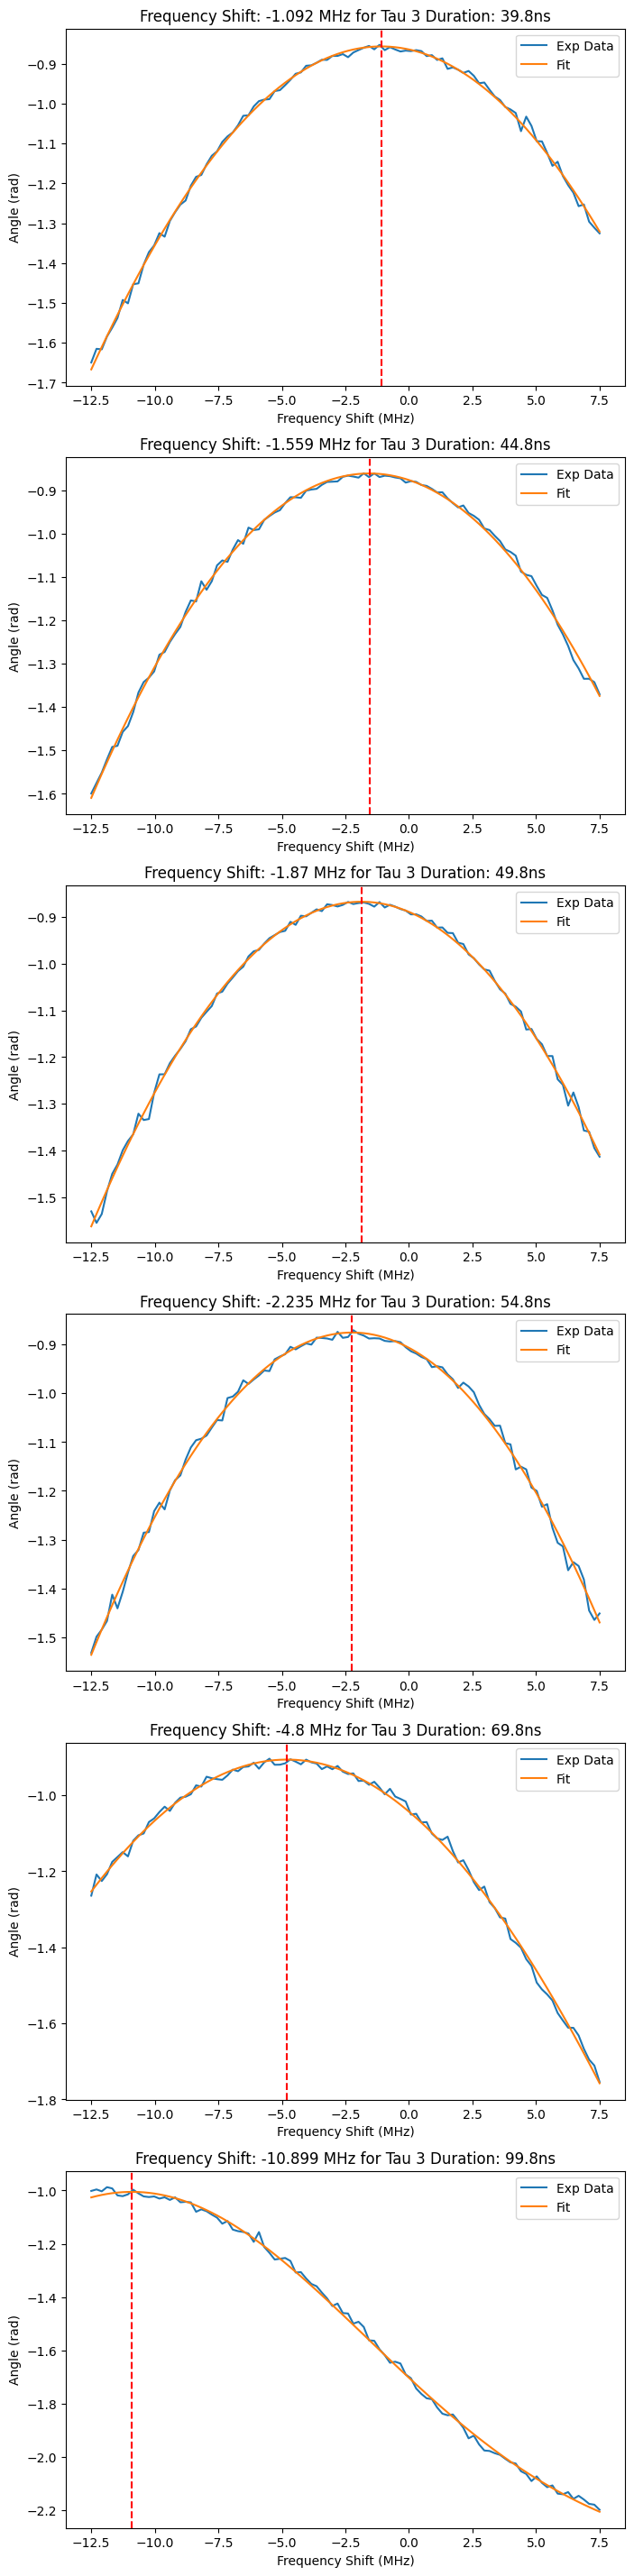

In [37]:
# Plotting Results

fig, ax = plt.subplots(len(tau_3_vals), figsize=(8.0, 6.0 * len(tau_3_vals)))

tau_3_vals_ns = np.round(tau_3_vals/ns, 2)

for i, (t_freq, t_params, t_exp_res) in enumerate(zip(tau_fit_freqs, tau_fit_params, angle_tau_reshaped)):
    ax[i].plot(tau_linspace_MHz, t_exp_res, label='Exp Data')
    ax[i].plot(tau_linspace_MHz, gaussian_func(tau_linspace_MHz, *t_params), label='Fit')
    ax[i].axvline(x=t_freq, linestyle='dashed', color='red')
    ax[i].set_xlabel('Frequency Shift (MHz)')
    ax[i].set_ylabel('Angle (rad)')
    ax[i].set_title(f'Frequency Shift: {t_freq} MHz for Tau 3 Duration: {tau_3_vals_ns[i]}ns')
    ax[i].legend()

plt.show()

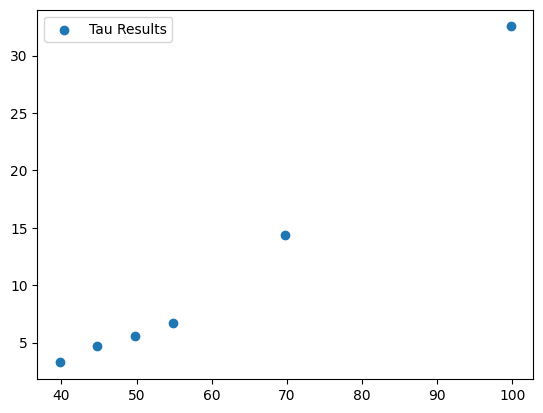

In [38]:
sherbrooke_chi_MHz = 0.335
tau_fit_photons = -tau_fit_freqs / sherbrooke_chi_MHz

plt.scatter(tau_3_vals_ns, tau_fit_photons, label='Tau Results')
plt.legend()
plt.show()